# Exemple d'application d'une méthode de pénalisation

Dans cette partie on se propose de résoudre le problème suivant : 

$$\left\{
    \begin{array}{ll}
        \Delta \Phi &= F &\text{sur } \Omega_i \\
        \Phi_{\partial \Omega_i} & = K \\
        \Phi_{\partial \Omega} & = 0 \\
    \end{array}
   \right.
$$

Nous avons vu en cours que ce problème est équivalent au suivant : 

$$\left\{
    \begin{array}{ll}
        \Delta \Phi_{\epsilon} &= \chi_{\Omega \backslash \Omega_i} \left(\dfrac{\Phi_{\epsilon}-K}{\epsilon}\right) + F &\text{sur  } \Omega \\
        \Phi_{\partial \Omega} & = 0 \\
    \end{array}
   \right.
$$

Avec 
$$\chi_{\Omega \backslash \Omega_i} = \left\{
    \begin{array}{ll}
      0 &\text{si   } x \in \Omega_i\\
      1 &\text{sinon} \\
    \end{array}
   \right.
$$

En effet, si l'on multiplie par $\epsilon$ de chaque côté de l'équation on obtient :

$$ \epsilon \Delta \Phi_{\epsilon} = \chi_{\Omega \backslash \Omega_i} (\Phi_{\epsilon}-K) + \epsilon F $$

On observe alors 2 cas de figures :

- $ x \in \Omega_i \Longrightarrow \Delta \Phi_{\epsilon} = F$
- $ x \in \Omega \backslash \Omega_i  $ alors on fait tendre $\epsilon$ vers 0 et on observe $(\Phi_{\epsilon}-K) = 0 \Longrightarrow \Phi_{\epsilon} = K$

L'exemple que nous allons résoudre est le suivant : 

<img src="pic3.jpg" width="300" height="300" align="center"/>

$$\left\{
    \begin{array}{ll}
        \Delta \Phi &= 1 &\text{sur } \Omega_i \\
        \Phi_{\partial \Omega_i} & = K \\
        \Phi_{\partial \Omega} & = 0 \\
    \end{array}
   \right.
$$

On connait une solution $\Phi$ de ce problème qui est la suivante : 

$$\Phi = \dfrac{1}{4} \times \left(x_1^2 + x_2^2\right) $$ 

Et $K = \dfrac{1}{4}\times R^2$ où $R$ est le rayon du cercle $\Omega_i$

Dans un premier temps, nous allons recopier la matrice du Laplacien, puis nous écrirons la fonction $\chi$ qui dépendra du rayon du cercle décrivant notre domaine $\Omega_i$. Le but est de pouvoir comparer notre résultat avec la solution exacte $\Phi$ et de finalement afficher les graphes d'erreur.

On commence par importer, comme d'habitude, les packages nécessaires.

In [2]:
import numpy as np                        #Package pour calculs scientifiques
import scipy.sparse as sparse             #Algèbre linéaire creuse
import matplotlib.pyplot as plt           #Permet la création de graphique  
import scipy.sparse.linalg as sci         #Contient plusieurs packages pour le calcul scientifique
from mpl_toolkits.mplot3d import Axes3D   #Utile pou le graphiques 3D
import time                               #Affichage du temps de calcul
from IPython.display import Image         #Affichage d'image dans le Jupyter

On écrit la fonction retournant la matrice de discrétisation du Laplacien sur l'intégralité des points du domaine.

In [4]:
def matrix_lap(N):
    """Retourne une matrice qui discrétise le laplacien de u dans le domaine Omega = [0,1]x[0,1], 
    découpé en N intervalles en x et y. La matrice finale est une matrice scipy.sparse CSR matrix. 
    Cette matrice est de taille (N+1)*(N+1)"""

    h = 1./N      #Longueur du pas d'espace
    h2 = h*h

    #On note les inconnues de 0 à Nx suivant x (axe des abscisses) 
    #et 0 à Ny suivant y (axe des ordonnées). 
    #La taille du problème est donc (Nx+1)*(Ny+1). 
    #Ici on prend le même pas d'espace en x et y
    #Cela correspond à x_i = i*h et y_j = j*h 
    #et la numérotation (i,j) --> k := (N+1)*j+i.

    taille = (1+N)*(1+N)
    
    #Rédaction de la matrice, on commence par effectuer 
    #le tableau des diagonales
    
    diags = np.zeros((5,taille))

    #Diagonale principale
    diags[2,:] = 1.
    diags[2, N+2:taille - (N+2)] = -4./h2
    diags[2, np.arange(2*N+1, taille, N+1)] = 1.
    diags[2, np.arange(2*N+2, taille, N+1)] = 1.
              
    #Diagonale "-1"
    diags[1,N+1:taille-(N+1)] = 1./h2
    diags[1, np.arange(2*N, taille, N+1)] = 0.
    diags[1, np.arange(2*N+1, taille, N+1)] = 0.
    
    #Diagonale "+1"
    diags[3, N+3:taille-(N+1)] = 1./h2
    diags[3, np.arange(2*N+2, taille, N+1)] = 0.
    diags[3, np.arange(2*N+3, taille, N+1)] = 0.

    #Diagonale "-(N+1)"
    diags[0, 1 : taille - (2*N+3)] = 1./h2
    diags[0, np.arange(N,taille,N+1)] = 0.
    diags[0, np.arange(N+1,taille,N+1)] = 0.

    #Diagonale "+(N+1)"
    diags[4, taille - N*N + 2 : taille - 1] = 1./h2
    diags[4, np.arange(taille - N*N + 1 + N ,taille,N+1)] = 0.
    diags[4, np.arange(taille - N*N + 2 + N ,taille,N+1)] = 0.

    #Construction de la matrice creuse
    A = sparse.spdiags(diags,[-(N+1),-1,0,1,(N+1)],taille,taille, format = "csr")

    return A

Puis on code les 2 fonctions dont nous avons besoin.

In [6]:
def func_ex(x,y):                                  #Retourne la fonction exacte solution
    return 0.25*((x-0.5)**2 + (y-0.5)**2)

def f(x,y):                                        #Retourne l'équation d'un cercle pour le codage de 'chi'
    return (x-0.5)**2 + (y-0.5)**2

Grâce à cela nous rédigeons la fonction $\chi$, fonction qui retourne 0 si $x$ appartient au cercle de rayon $R$ choisi par l'utilisateur et 1 si $x$ est en dehors de ce cercle.

In [9]:
def Xhi(f,R):
    """R est le rayon du masque"""
    if f <= R**2:
        return 0
    else:
        return 1

Finalement nous pouvons créer notre masque, c'est à dire une fonction qui va retourner une matrice sparse de taille (N+1)x(N+1) où il y aura des 0 partout dans le cercle de rayon R et des 1 à l'extérieur.

In [28]:
def masque(f,R,N):
    """Retourne une matrice qui discrétise le masque du domaine grâce à la fonction Xhi précédente, 
    la matrice créée est une matrice sparse de taille (N+1)*(N+1)"""

    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)
    
    taille = (N+1)*(N+1)
    
    diags = np.zeros((1,taille))
    
    #Diagonale principale
    for i in range(N+1):
        for j in range(N+1):
            k = i + j*(N+1)
            diags[0,k] = Xhi(f(x[i],y[j]),R)

    diags[0,0:N+2] = 1
    diags[0,taille-(N+2):taille] = 1
    diags[0, np.arange(2*N+1, taille, N+1)] = 1
    diags[0, np.arange(2*N+2, taille, N+1)] = 1

    M = sparse.spdiags(diags,0,taille,taille,format = 'csr')
    
    return M

La fonction suivante retourne la solution exacte afin de pouvoir effectuer les comparaisons.

In [30]:
def sol_ex(f,R,N):

    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)

    E = np.zeros((N+1)*(N+1))

    for i in range(N+1):
        for j in range(N+1):
            k = i + j*(N+1)
            if f(x[i],y[j]) <= R**2 :
                E[k] = func_ex(x[i],y[j])
            else :
                E[k] = 0.25*R**2
            
    return E

Et finalement on implémente la solution de la pénalisation

In [31]:
def sol_penal(f,R,N,eta):
    taille = (N+1)*(N+1)
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)    

    A = matrix_lap(N)
    B = masque(f,R,N)
    
    DISC = (A -(1/eta)*B)
        
    F = np.zeros(taille)
    
    for i in range (N+1):
        for j in range(N+1):
            k = i + j*(N+1)
            F[k] = - 0.25*R**2*Xhi(f(x[i],y[j]),R)/eta + 1 


    U = sci.spsolve(DISC,F)
    
    return U

On affiche les graphes entre la solution de pénalisation et notre solution exacte pour un rayon $R = 0.2$ et un nombre de point $N = 100$. On se propose 2 types d'affichage différents. Le premier sera un affichage '2D'en terme de courbes de niveaux, le second une représentation '3D' de la solution.

In [34]:
def graphe(f,R,N,eta):
    taille = (N+1)*(N+1)
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)
    
    A = sol_penal(f,R,N,eta)
    B = sol_ex(f,R,N)

    fig = plt.figure(figsize = [15,6])
    ax = fig.add_subplot(1,2,1)
    X,Y = np.meshgrid(x,y)
    ax.contour(X,Y,A.reshape(N+1,N+1) ,cmap='hot')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title('Solution pénalisée')
    
    ax = fig.add_subplot(1,2,2)
    X,Y = np.meshgrid(x,y)
    ax.contour(X,Y,B.reshape(N+1,N+1),cmap='hot')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title('Solution exacte')
    
    fig2 = plt.figure(figsize = [15,6])
    ax = fig2.add_subplot(1,2,1, projection = '3d')
    X,Y = np.meshgrid(x,y)
    ax.plot_surface(X,Y,A.reshape(N+1,N+1) ,cmap='hot')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title('Solution pénalisée')
    
    ax = fig2.add_subplot(1,2,2,projection = '3d')
    X,Y = np.meshgrid(x,y)
    ax.plot_surface(X,Y,B.reshape(N+1,N+1),cmap='hot')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title('Solution exacte')
    
    plt.show()

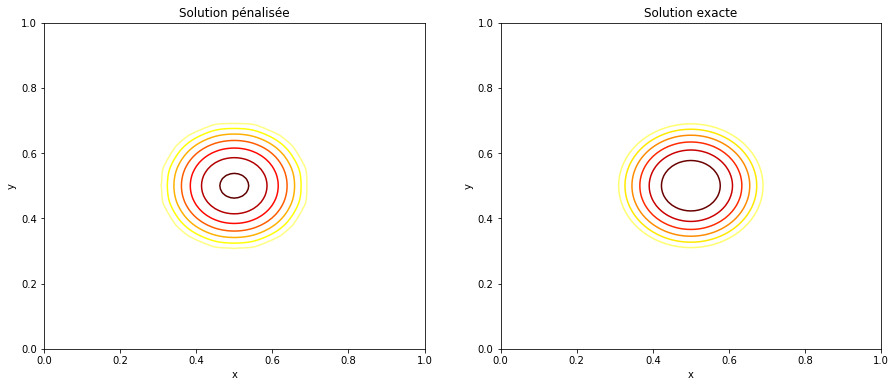

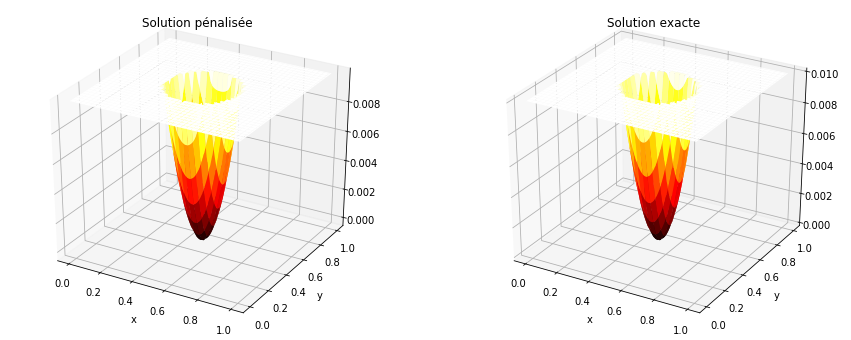

In [36]:
graphe(f,0.2,100,0.0000001)

Nous pouvons remarquer que les 2 graphiques sont relativement similaires. On peut donc penser que notre approximation est juste. Cependant les représentations graphiques ne suffisant pas à prouver la justesse de notre travail, nous allons afficher les graphiques d'erreur. Nous étudierons l'erreur absolue ainsi que l'erreur euclidienne. Nous avons vu pendant le cours que la méthode de pénalisation telle que nous l'avons rédigée est une méthode d'approximation d'ordre 1. On s'attend donc à ce que les droites de régression linéaire correspondant aux erreurs aient une pente de -1. 

In [37]:
def erreur_abs(A,E,N):
    return np.max(np.abs(A - E))

def erreur_eucl(A,E,N):
    return np.sqrt(np.sum(((E-A)**2))/(N+1)**2)

def aff(x,b,a):
    return np.exp(b)*x**(a)

In [43]:
def graphe_erreur(f,R,N,eta):
    tab_err = np.zeros(N)
    tab_err2 = np.zeros(N)

    ERR1 = np.zeros(N)
    ERR2 = np.zeros(N)

    x = np.linspace(1,N,N)

    for i in range(1,N+1):        
        V = sol_penal(f, R, i, eta)
        U = sol_ex(f,R,i)

        tab_err[i-1] = erreur_abs(V,U,i)
        tab_err2[i-1] = erreur_eucl(V,U,i)

    x1 = x[N-50:N]
    Err1 = tab_err[N-50:N]
    Err2 = tab_err2[N-50:N]
    z1 = np.polyfit(np.log(x1),np.log(Err1),1)
    z2 = np.polyfit(np.log(x1),np.log(Err2),1)
        
    y1 = aff(x,z1[1],z1[0])[N-50:N]  
    y2 = aff(x,z2[1],z2[0])[N-50:N]

    plt.figure(figsize = [15,8])
    
    plt.plot(x1,Err1,color='blue',marker='o', linestyle='none')
    plt.plot(x1,Err2,color='green',marker='+', linestyle='none')
    plt.plot(x1,y1,color='r', linestyle='-')
    plt.plot(x1,y2,color='r', linestyle='-')
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel('N')
    plt.ylabel('Erreur log: Eucl (vert), Abs (bleu)')

    plt.show()

    return z1[0],z2[0]

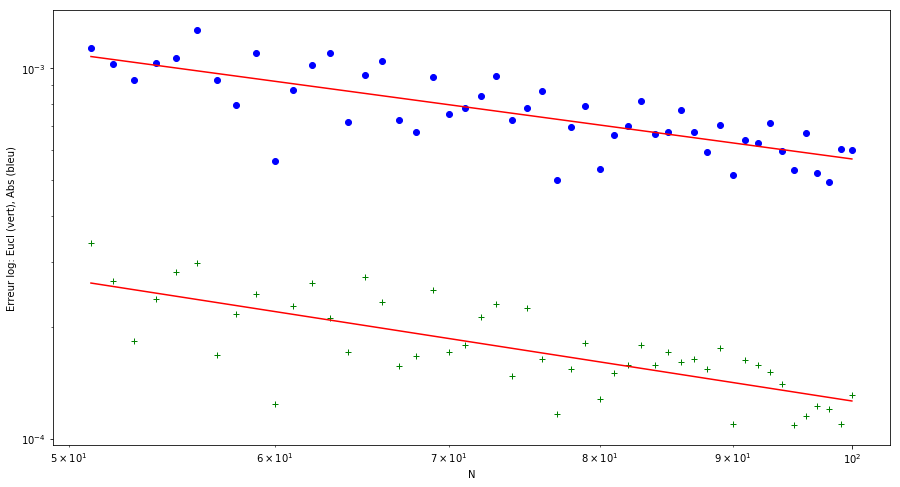

(-0.9450788534430512, -1.088263481169789)

In [44]:
graphe_erreur(f,0.2,100,0.0000001)

Nous pouvons finalement remarquer que nos 2 coefficients directeurs ont une pente d'environ -1. Cela prouve la justesse de notre approximation. Nous avons ainsi développé un exemple d'une méthode de pénalisation, méthode permettant d'approcher la solution d'équations aux dérivées partielles dans des domaines précis.